In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image, ImageFile
import numpy as np
import cv2
from skimage import exposure
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [25]:
import os

# Show current working directory
print("Before:", os.getcwd())

# Change to the correct folder if needed
os.chdir(r"E:\EmbryoAnalysis\EmbryoAnalysis")
print("After:", os.getcwd())

Before: e:\EmbryoAnalysis\EmbryoAnalysis\Notebooks\AHE+UNET
After: E:\EmbryoAnalysis\EmbryoAnalysis


In [7]:
pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.7 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 3.8 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 3.8 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 3.9 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 4.0 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 4.3 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 4.4 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 4.0 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.1 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install scikit-image

  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 2.4 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/12.9 MB 2.2 MB/s eta 0:00:06
   ------ --------------------------------- 2.1/12.9 MB 2.7 MB/s eta 0:00:05
   -------- ------------------------------- 2.6/12.9 MB 2.6 MB/s eta 0:00:04
   --------- ------------------------------ 3.1/12.9 MB 2.8 MB/s eta 0:00:04
   ------------- -------------------------- 4.2/12.9 MB 3.0 MB/s eta 0:00:03
   --------------- ------------------------ 5.0/12.9 MB 3.1 MB/s eta 0:00:03
   ----------------- ---------------------- 5.8/12.9 MB 3.2 MB/s eta 0:00:03
   --------------------- ------------------ 6.8/12.9 MB 3.4 MB/s eta 0:00:02
   ----------------------- ---------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
    --------------------------------------- 0.5/39.0 MB 5.0 MB/s eta 0:00:08
   - -------------------------------------- 1.3/39.0 MB 4.4 MB/s eta 0:00:09
   - -------------------------------------- 1.3/39.0 MB 4.4 MB/s eta 0:00:09
   - -------------------------------------- 1.6/39.0 MB 1.9 MB/s eta 0:00:20
   --- ------------------------------------ 3.1/39.0 MB 3.3 MB/s eta 0:00:11
   --- ------------------------------------ 3.4/39.0 MB 3.4 MB/s eta 0:00:11
   ---- ----------------------------------- 3.9/39.0 MB 2.9 MB/s eta 0:00:13
   ---- ----------------------------------- 3.9/39.0 MB 2.9 MB/s eta 0:00:13
   ---- ----------------------------------- 4.5/39.0 MB 2.6 MB/s eta 0:00:14
   ---- ----------------------------------- 4.7/39.0 MB 2.5 MB/s eta 0:00:14
   ----- ---------------------------------- 5.8/39.0 MB 2.7 MB/s eta 0:00:13
   ------ --------------------------------- 6.8/39.0 MB 2.8 MB/s eta 0:00:12
   ---

In [9]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance image contrast.
    
    Args:
        image (PIL.Image or numpy.ndarray): Input grayscale image
        clip_limit (float): Threshold for contrast limiting
        tile_grid_size (tuple): Size of the grid for adaptive equalization
    
    Returns:
        PIL.Image: Enhanced image
    """
    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image
    
    # Apply CLAHE using OpenCV
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(img_array)
    
    # Convert back to PIL Image
    if isinstance(image, Image.Image):
        return Image.fromarray(enhanced)
    else:
        return enhanced

def apply_adaptive_histogram_equalization(image, kernel_size=None):
    """
    Apply Adaptive Histogram Equalization using scikit-image.
    
    Args:
        image (PIL.Image or numpy.ndarray): Input grayscale image
        kernel_size (int or None): Size of the local neighborhood. If None, uses image_size/8
    
    Returns:
        PIL.Image: Enhanced image
    """
    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image
    
    # Set default kernel size
    if kernel_size is None:
        kernel_size = min(img_array.shape) // 8
        kernel_size = max(kernel_size, 8)  # Minimum kernel size
    
    # Apply adaptive histogram equalization
    enhanced = exposure.equalize_adapthist(img_array, kernel_size=kernel_size)
    enhanced = img_as_ubyte(enhanced)
    
    # Convert back to PIL Image
    if isinstance(image, Image.Image):
        return Image.fromarray(enhanced)
    else:
        return enhanced

def enhance_embryo_image(image, method='clahe', **kwargs):
    """
    Enhance embryo image using specified method.
    
    Args:
        image (PIL.Image): Input grayscale image
        method (str): 'clahe' or 'ahe'
        **kwargs: Additional parameters for enhancement methods
    
    Returns:
        PIL.Image: Enhanced image
    """
    if method == 'clahe':
        # Filter kwargs to include only parameters accepted by apply_clahe
        params = {k: v for k, v in kwargs.items() if k in ['clip_limit', 'tile_grid_size']}
        return apply_clahe(image, **params)
    elif method == 'ahe':
        # Filter kwargs to include only parameters accepted by apply_adaptive_histogram_equalization
        params = {k: v for k, v in kwargs.items() if k in ['kernel_size']}
        return apply_adaptive_histogram_equalization(image, **params)
    else:
        raise ValueError("Method must be 'clahe' or 'ahe'")

In [10]:
def get_common_embryo_ids(base_paths):
    """
    Returns a sorted list of folder names (embryo IDs)
    that appear in *all* the given directories.
    """
    sets_of_ids = []
    for path in base_paths:
        subfolders = [
            d for d in os.listdir(path)
            if os.path.isdir(os.path.join(path, d))
        ]
        sets_of_ids.append(set(subfolders))

    common_ids = set.intersection(*sets_of_ids)
    return sorted(list(common_ids))

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=1):
        """
        U-Net model that takes 6-channel input (one for each focal plane)
        and outputs a single-channel fused image.
        """
        super(UNet, self).__init__()
        
        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.conv5 = DoubleConv(512, 1024)
        
        # Decoder
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        
        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        
        # Bottleneck
        c5 = self.conv5(p4)
        
        # Decoder
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        
        # Output with Sigmoid (values in [0,1])
        output = self.conv10(c9)
        return torch.sigmoid(output)


In [12]:
class EmbryoFocusStackDataset(Dataset):
    """
    Each item in this dataset is a (input_tensor, target_tensor) pair.
    input_tensor has shape (6, H, W), one channel per focal plane.
    Now includes adaptive histogram equalization for enhancement.
    """
    def __init__(self, base_paths, embryo_ids, transform=None, enhance_method='clahe', enhance_params=None):
        if len(base_paths) != 6:
            raise ValueError("We need exactly 6 focal-plane directories.")
        
        self.base_paths = base_paths
        self.embryo_ids = embryo_ids
        self.transform = transform
        self.enhance_method = enhance_method
        self.enhance_params = enhance_params or {}

    def __len__(self):
        return len(self.embryo_ids)

    def __getitem__(self, idx):
        embryo_id = self.embryo_ids[idx]
        
        focal_images = []
        for path in self.base_paths:
            embryo_subfolder = os.path.join(path, embryo_id)
            image_files = sorted(
                [f for f in os.listdir(embryo_subfolder)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            )
            if not image_files:
                raise FileNotFoundError(f"No image found in {embryo_subfolder}")
            
            img_path = os.path.join(embryo_subfolder, image_files[0])
            
            # Load image
            image = Image.open(img_path).convert('L')
            
            # Apply adaptive histogram equalization for enhancement
            if self.enhance_method:
                image = enhance_embryo_image(image, method=self.enhance_method, **self.enhance_params)
            
            # Apply other transforms (resize, ToTensor, etc.)
            if self.transform:
                image = self.transform(image)
            
            focal_images.append(image)
        
        input_tensor = torch.cat(focal_images, dim=0)
        target = focal_images[2]  # dummy target
        return input_tensor, target


In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten the tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice_score

def combined_loss(output, target):
    """Combined Dice + L1 Loss"""
    dice_loss_fn = DiceLoss()
    l1_loss_fn = nn.L1Loss()
    
    dice = dice_loss_fn(output, target)
    l1 = l1_loss_fn(output, target)
    total_loss = dice + l1
    return total_loss

In [14]:
def train_model(model, train_loader, val_loader, num_epochs=5, device='cpu'):
    """
    Trains the U-Net using BCE + Dice Loss.
    Saves the best model to 'embryo_unet_ahe.pth'.
    """
    bce_loss = nn.BCELoss()
    dice_loss = DiceLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Combined loss
            loss = bce_loss(outputs, targets) + dice_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = bce_loss(outputs, targets) + dice_loss(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'embryo_unet_ahe.pth')
            print(f"  [*] Model saved at epoch {epoch+1}")


In [15]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms

def test_single_embryo(
    model,
    image_paths,
    transform,
    device='cpu',
    enhance_method='clahe',
    enhance_params=None,
    save_dir=None
):
    """
    Loads 6 images from different focal planes, applies enhancement (CLAHE or AHE),
    saves each enhanced input, stacks them as 6-channel input, and returns the fused output image.
    
    Args:
        model (nn.Module): Trained UNet model with 6 input channels.
        image_paths (list[str]): List of 6 image file paths (one per focal plane).
        transform (callable): Same transform used in training (resize, ToTensor, etc.).
        device (str): 'cpu' or 'cuda'.
        enhance_method (str): 'clahe' or 'ahe' for enhancement method.
        enhance_params (dict): Parameters for enhancement method.
        save_dir (str or None): Directory to write enhanced inputs. If None, skips saving.
        
    Returns:
        PIL.Image: The fused output image (single-channel).
    """
    if enhance_params is None:
        enhance_params = {}

    # Make sure the model is in eval mode
    model.eval()
    
    # Create save directory if requested
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    focal_tensors = []
    for idx, path in enumerate(image_paths, start=1):
        # 1) Load & grayscale
        img = Image.open(path).convert('L')
        
        # 2) Apply enhancement
        if enhance_method:
            img = enhance_embryo_image(img, method=enhance_method, **enhance_params)
        
            # 3) Save the enhanced input for inspection
            if save_dir:
                filename = f"enhanced_input_{idx}_{enhance_method}.jpg"
                img.save(os.path.join(save_dir, filename))
                print(f"[Saved] {filename}")
        
        # 4) Transform to tensor
        img_tensor = transform(img)
        focal_tensors.append(img_tensor)
    
    # 5) Stack into one 6‑channel tensor
    input_tensor = torch.cat(focal_tensors, dim=0)          # (6, H, W)
    input_tensor = input_tensor.unsqueeze(0).to(device)     # (1, 6, H, W)
    
    # 6) Forward pass
    with torch.no_grad():
        output = model(input_tensor)                        # (1, 1, H, W)
    
    # 7) Convert to PIL
    output_image = output.squeeze(0).cpu()                  # (1, H, W)
    fused_pil = transforms.ToPILImage()(output_image)
    
    return fused_pil


In [16]:
def visualize_enhancement_comparison(image_path, save_path=None):
    """
    Visualize the effect of different enhancement methods on an embryo image.
    """
    # Load original image
    original = Image.open(image_path).convert('L')
    
    # Apply different enhancement methods
    clahe_enhanced = apply_clahe(original, clip_limit=2.0, tile_grid_size=(8, 8))
    ahe_enhanced = apply_adaptive_histogram_equalization(original, kernel_size=32)
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(clahe_enhanced, cmap='gray')
    axes[1].set_title('CLAHE Enhanced')
    axes[1].axis('off')
    
    axes[2].imshow(ahe_enhanced, cmap='gray')
    axes[2].set_title('AHE Enhanced')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [18]:
def main():
    import os
    import torch
    from torchvision import transforms
    from torch.utils.data import DataLoader, random_split

    # Paths to your 6 focal-plane directories (edit as needed)
    base_paths = [
        r"E:\EmbryoAnalysis\EmbryoAnalysis\Dataset\embryo_dataset_F15.tar\embryo_dataset_F15",
        r"E:\EmbryoAnalysis\EmbryoAnalysis\Dataset\embryo_dataset_F-15.tar\embryo_dataset_F-15",
        r"E:\EmbryoAnalysis\EmbryoAnalysis\Dataset\embryo_dataset_F30.tar\embryo_dataset_F30",
        r"E:\EmbryoAnalysis\EmbryoAnalysis\Dataset\embryo_dataset_F-30.tar\embryo_dataset_F-30",
        r"E:\EmbryoAnalysis\EmbryoAnalysis\Dataset\embryo_dataset_F45.tar\embryo_dataset_F45",
        r"E:\EmbryoAnalysis\EmbryoAnalysis\Dataset\embryo_dataset_F-45.tar\embryo_dataset_F-45"
    ]
    
    try:
        # Step 1: Get common embryo IDs
        embryo_ids = get_common_embryo_ids(base_paths)
        print(f"[INFO] Found {len(embryo_ids)} common embryo IDs")

        # Step 2: Define image transform
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

        # Step 3: Enhancement parameters
        enhance_params = {
            'clip_limit': 3.0,
            'tile_grid_size': (8, 8),
            'kernel_size': 32
        }

        # Step 4: Create dataset
        dataset = EmbryoFocusStackDataset(
            base_paths,
            embryo_ids,
            transform=transform,
            enhance_method='clahe',  # or 'ahe'
            enhance_params=enhance_params
        )

        # Step 5: Train-validation split
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        print(f"[INFO] Dataset split: {train_size} train / {val_size} val")

        # Step 6: DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

        # Step 7: Setup device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[INFO] Using device: {device}")

        # Step 8: Initialize model
        model = UNet(in_channels=6, out_channels=1).to(device)

        # Step 9: Train model
        print("[INFO] Starting training with histogram equalization...")
        train_model(model, train_loader, val_loader, num_epochs=50, device=device)

        # Step 10: Save model
        torch.save(model.state_dict(), "embryo_unet_ahe.pth")
        print("[SUCCESS] Training complete. Model saved as 'embryo_unet_ahe.pth'.")
    except Exception as e:
        print(f"[ERROR] {e}")


[Saved] enhanced_input_1_clahe.jpg
[Saved] enhanced_input_2_clahe.jpg
[Saved] enhanced_input_3_clahe.jpg
[Saved] enhanced_input_4_clahe.jpg
[Saved] enhanced_input_5_clahe.jpg
[Saved] enhanced_input_6_clahe.jpg
Enhanced fused image saved as 'fused_output_ahe.jpg'


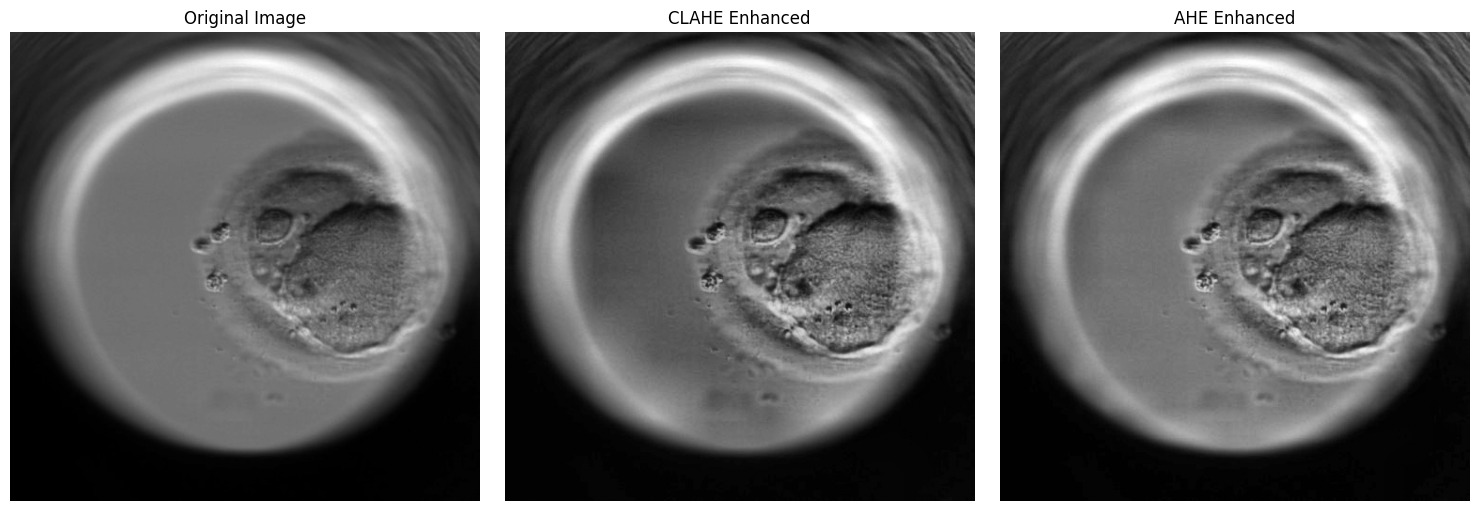

In [26]:
def main_test():
    # Example test image paths
    test_image_paths = [
        r"C:\Users\pande\OneDrive\Desktop\inputs\input1.jpeg",
        r"C:\Users\pande\OneDrive\Desktop\inputs\input2.jpeg",
        r"C:\Users\pande\OneDrive\Desktop\inputs\input3.jpeg",
        r"C:\Users\pande\OneDrive\Desktop\inputs\input4.jpeg",
        r"C:\Users\pande\OneDrive\Desktop\inputs\input5.jpeg",
        r"C:\Users\pande\OneDrive\Desktop\inputs\input6.jpeg"
    ]
    
    # Define transform
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(in_channels=6, out_channels=1).to(device)
    model.load_state_dict(torch.load("embryo_unet_ahe.pth", map_location=device))
    model.eval()

    # Paths & params
    enh_params = {'clip_limit': 3.0, 'tile_grid_size': (8, 8)}

    # Run
    fused = test_single_embryo(
        model,
        test_image_paths,
        transform,
        device=device,
        enhance_method='clahe',
        enhance_params=enh_params,
        save_dir="./enhanced_inputs"
    )

    # Save final fused output
    fused.save("fused_output.jpg")

    print("Enhanced fused image saved as 'fused_output_ahe.jpg'")
    
    # Visualize enhancement comparison for the first image
    if os.path.exists(test_image_paths[0]):
        visualize_enhancement_comparison(test_image_paths[0], "enhancement_comparison.jpg")

def test_enhancement_only():
    """Test enhancement methods on a single image"""
    test_image_path = r"C:\Projects\Embryo\Dataset\embryo_dataset_F15\AB91-1\D2013.01.29_S0719_I132_WELL1_RUN169.jpeg"
    
    if os.path.exists(test_image_path):
        visualize_enhancement_comparison(test_image_path, "enhancement_comparison.jpg")
        print("Enhancement comparison saved as 'enhancement_comparison.jpg'")
    else:
        print(f"Test image not found: {test_image_path}")

if __name__ == "__main__":
    # Uncomment the function you want to run:
    # main()  # For training
    main_test()  # For testing with trained model
    # test_enhancement_only()  # For testing enhancement methods only